In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.45355422 0.875      0.18605264 0.115     ]
 [0.4670082  0.625      0.11139931 0.21240863]
 [0.59990386 0.375      0.21938114 0.21938114]
 [0.3553578  0.125      0.14669009 0.14669009]]
[0. 0. 2. 2.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

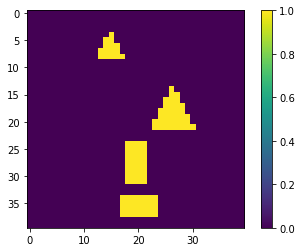

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 1000
lr         = 0.001
print_step = 100

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=32)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=32, 
                   window_size=20, hidden_size=64)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=64, num_classes=3, obj_threshold=0.9, scope='rcnn')


crop_conv, sel_real_box, sel_real_box_xy_rot = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

#RCNN loss
rcnn_label   = tf.boolean_mask(y_label_tf, rcnn.selected)
rcnn_box_gt  = tf.boolean_mask(y_box_tf, rcnn.selected)
rcnn_rpn_box = tf.boolean_mask(list_box, rcnn.selected)

print(rcnn_label, rcnn_box_gt, rcnn_rpn_box, rcnn.box_adjust)

loss_rcnn    = 10*tf.reduce_sum(rcnn_label*tf.reduce_sum(tf.square(
        (rcnn_box_gt-rcnn_rpn_box)-rcnn.box_adjust 
        ),axis=1))

print(loss_class, loss_box, loss_rcnn, loss)

W0822 11:05:15.208021 140090174510912 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0822 11:05:15.209624 140090174510912 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0822 11:05:15.210935 140090174510912 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0822 11:05:15.271639 140090174510912 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/layer

Tensor("boolean_mask_1/GatherV2:0", shape=(?,), dtype=float32) Tensor("boolean_mask_2/GatherV2:0", shape=(?, 4), dtype=float32) Tensor("boolean_mask_3/GatherV2:0", shape=(?, 4), dtype=float32) Tensor("box_fc/Tanh:0", shape=(?, 4), dtype=float32)
Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("mul_9:0", shape=(), dtype=float32) Tensor("add_4:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,lrc,ls = sess.run(
            [loss, loss_class, loss_box, loss_rcnn, lab_sum], 
            {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, 
             y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f}\
        loss_box={:.3f}, loss_rcnn={:.3f}\
        lab_sum={:.1f}".format(i,l, lc, lb, lrc, ls))

iteration 0: loss=4233.607 loss_class=4224.347        loss_box=9.261, loss_rcnn=0.000        lab_sum=24.0
iteration 100: loss=71.032 loss_class=62.575        loss_box=8.457, loss_rcnn=0.000        lab_sum=12.0
iteration 200: loss=33.836 loss_class=27.572        loss_box=6.264, loss_rcnn=0.000        lab_sum=16.0
iteration 300: loss=5.240 loss_class=4.214        loss_box=1.026, loss_rcnn=0.000        lab_sum=4.0
iteration 400: loss=10.926 loss_class=10.372        loss_box=0.555, loss_rcnn=0.000        lab_sum=2.0
iteration 500: loss=4.967 loss_class=1.961        loss_box=3.006, loss_rcnn=3.040        lab_sum=6.0
iteration 600: loss=10.598 loss_class=2.442        loss_box=8.156, loss_rcnn=5.698        lab_sum=11.0
iteration 700: loss=11.158 loss_class=10.872        loss_box=0.286, loss_rcnn=0.274        lab_sum=4.0
iteration 800: loss=4.635 loss_class=4.506        loss_box=0.129, loss_rcnn=0.067        lab_sum=2.0
iteration 900: loss=2.727 loss_class=0.718        loss_box=2.009, loss_rcn

In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

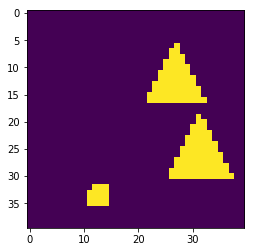

0


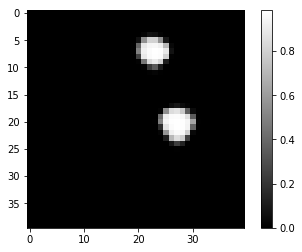

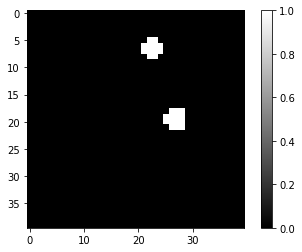

1


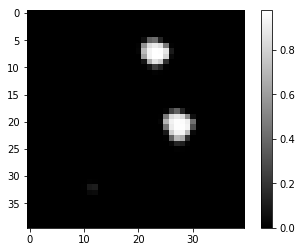

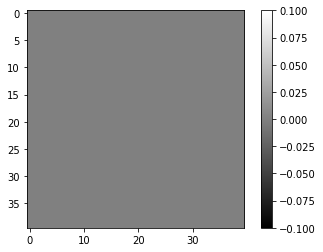

2


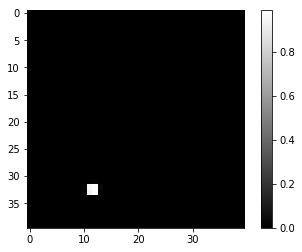

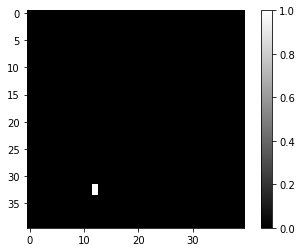

3


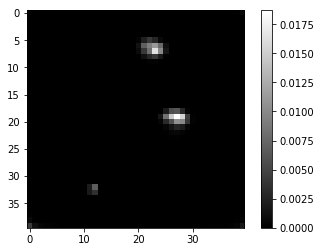

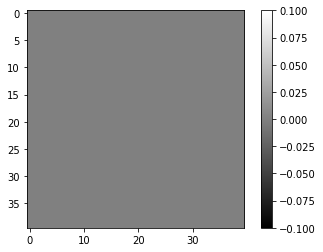

weights
0


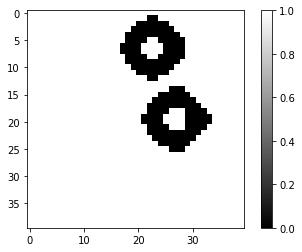

1


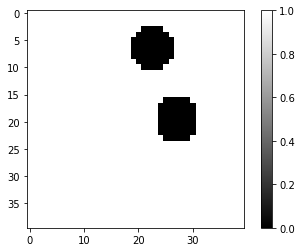

2


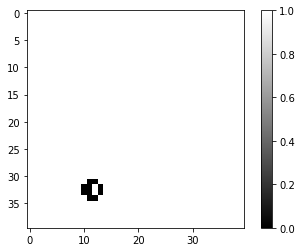

3


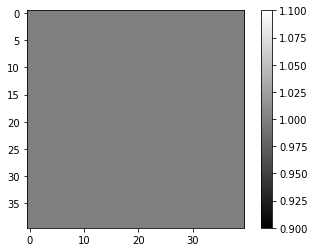

In [12]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [13]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [14]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]

In [15]:
bp = predicted_boxes[predicted_obj>0.9]

In [16]:
gt_p = gt_t[predicted_obj>0.9]

In [17]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[24.01440356  7.96194954 11.16357565 12.22404242]
 [24.38991055  8.40994836 10.94204664 12.37214756]
 [24.69978924  8.71210421 11.00780082 12.63624001]
 [23.25840411  8.44545899 11.48249888 12.27562523]
 [23.8395339   8.95888252 11.06030488 12.29506302]
 [23.13793192  6.97381799  9.3178854   9.75422955]
 [23.9983624   9.50962229 10.80770373 12.5922575 ]
 [23.53658301  6.88768358  9.32878208  9.65522671]
 [24.246273    9.71798862 10.83026075 12.89502239]
 [23.95445356  7.00652945  9.358531    9.74747372]
 [23.44821006  9.99324573 11.05557275 12.39232063]
 [23.14009682  7.49043567  9.74840069 10.15130711]
 [23.64783665 10.50268699 10.79942536 12.68883419]
 [23.53699165  7.30818905  9.84031105 10.2446394 ]
 [23.84337968 10.8079095  10.81199455 12.88355684]
 [23.92580471  7.38986863  9.97229004 10.33657455]
 [22.66861588 11.78761037 11.71594191 12.9555645 ]
 [27.02814541 20.4162578  12.28811216 11.90132403]
 [27.95250873 20.31242689 12.07037258 11.70405936]
 [28.58647678 20.46311393 12.02

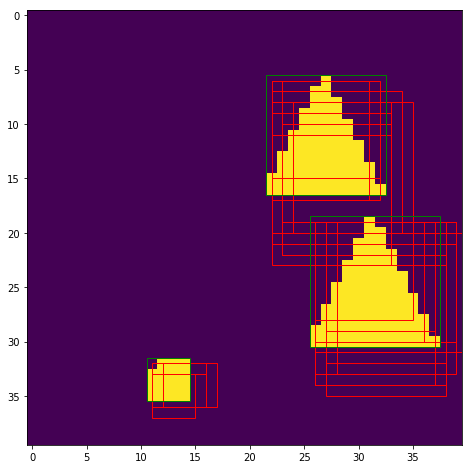

In [18]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [19]:
cropped = sess.run(crop_conv,{x_tf:x})

In [20]:
print(cropped.shape)

(47, 30, 30, 1)


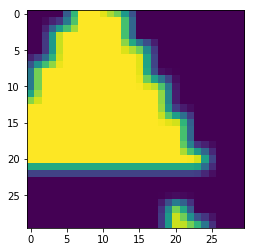

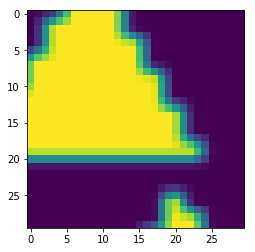

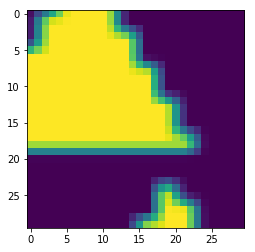

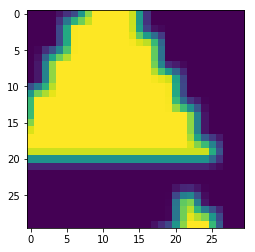

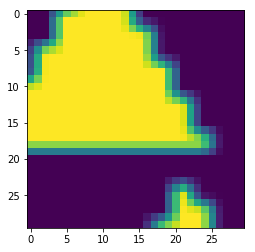

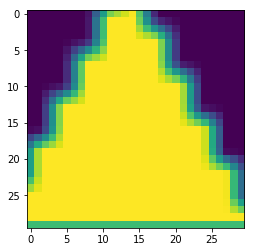

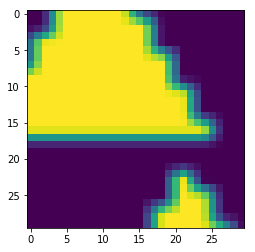

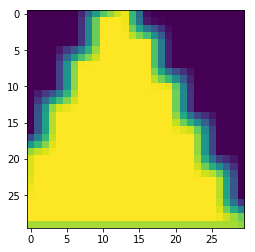

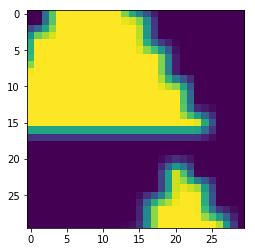

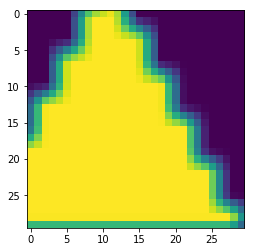

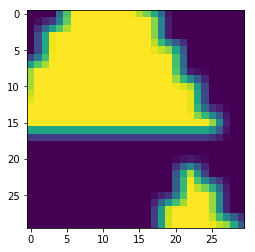

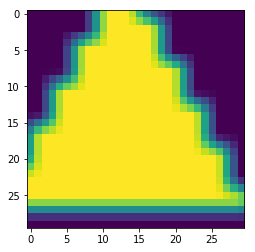

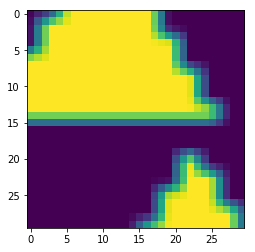

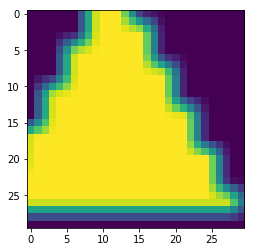

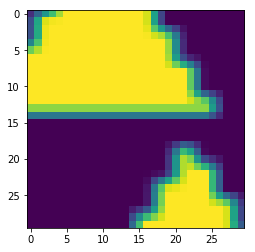

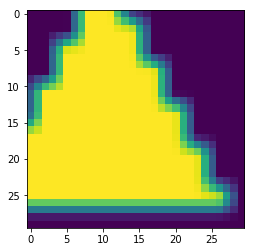

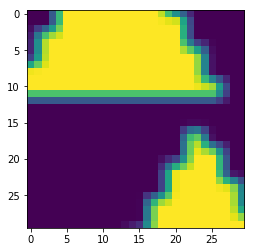

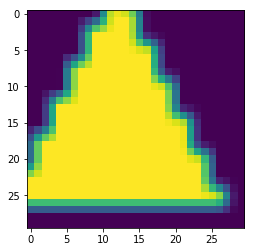

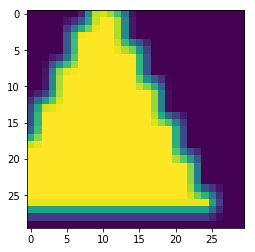

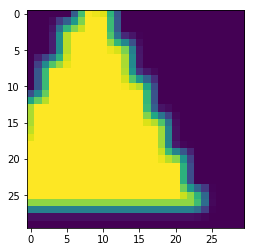

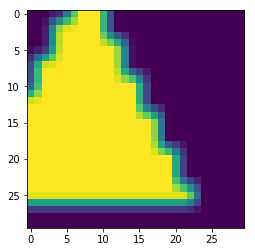

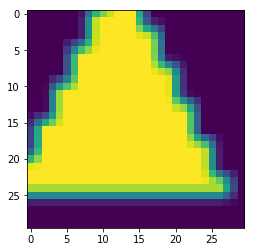

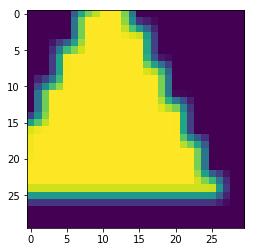

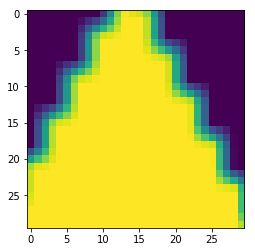

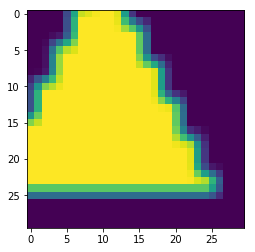

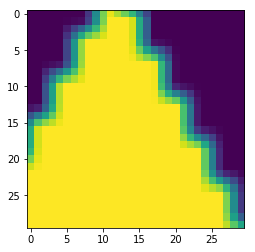

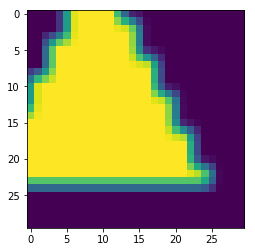

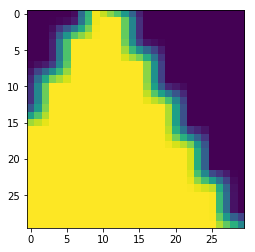

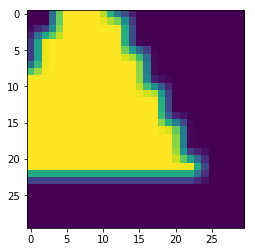

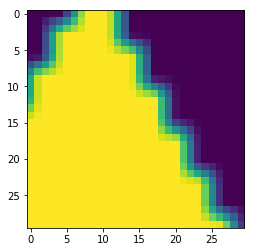

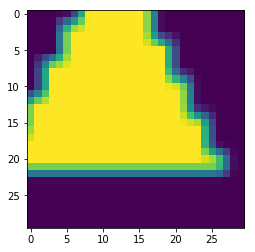

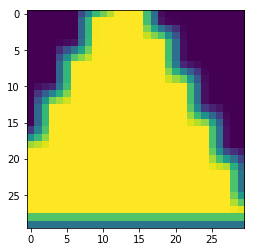

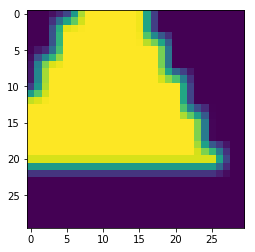

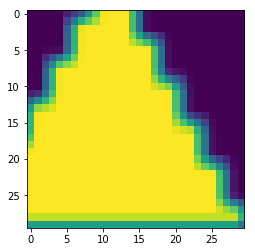

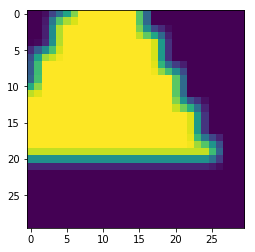

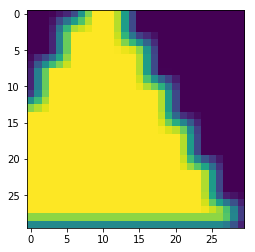

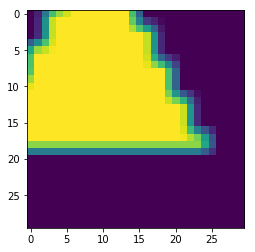

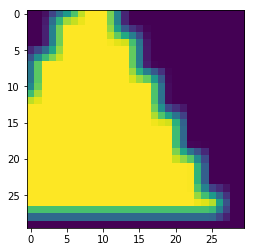

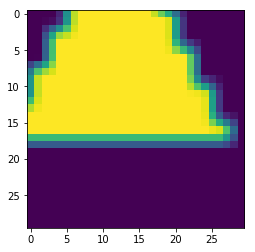

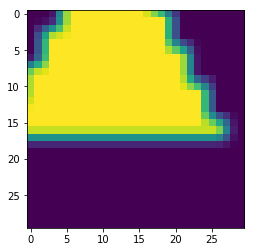

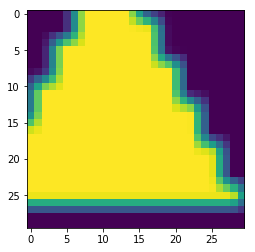

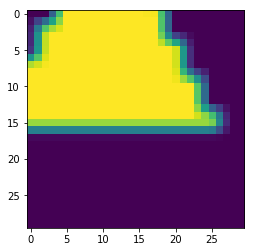

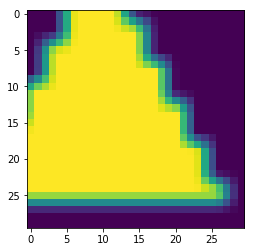

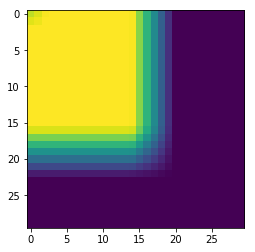

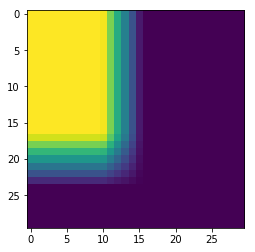

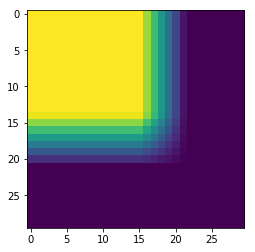

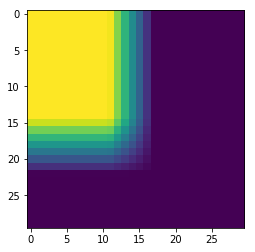

In [21]:
for n in range(cropped.shape[0]):
    plt.figure()
    plt.imshow(cropped[n,:,:,0])
    plt.show()

In [21]:
real_box, real_box_xy_rot = sess.run([sel_real_box, sel_real_box_xy_rot], {x_tf:x})
print(real_box[:4]*H)
print(real_box_xy_rot[:4]*H)
print(bp_n[:4]*H)

[[25.497894   6.775051  12.115569  12.057808 ]
 [25.749788   6.6660566 11.902133  11.778031 ]
 [26.012482   6.3667383 11.556239  11.628913 ]
 [25.131165   7.0629253 11.964974  11.900961 ]]
[[ 6.775051  25.497894  18.832859  37.613464 ]
 [ 6.6660566 25.749788  18.444088  37.65192  ]
 [ 6.3667383 26.012482  17.995651  37.56872  ]
 [ 7.0629253 25.131165  18.963886  37.096138 ]]
[[25.49789218  6.77505124 12.11556816 12.05780697]
 [25.74978731  6.66605628 11.90213299 11.77803111]
 [26.01248286  6.36673803 11.55623889 11.62891173]
 [25.13116333  7.06292502 11.96497393 11.9009614 ]]
